In [1]:
%load_ext autotime
%matplotlib inline

In [2]:
import pandas as pd
import re
import spacy
import glob
# import pathos
import os
import numpy as np
import gc
from collections import Counter

time: 487 ms


In [3]:
space_normalize_text_pattern = re.compile('[\.\s]{2,}')  # sub with ' . '?
noise_normalize_text_pattern = re.compile('[^a-z\'\.\?\!\s]+')  # sub with ' '
white_space_normalize = re.compile('\s+')  # sub with ' '
normalize_citations = re.compile(r'([a-zA-Z]+)(\.[0-9]+) ')  # sub with r'\1. '  Example: wb_10000577 "liberalization.3 "  Check with re.findall(r'[a-zA-Z]+\.[0-9]+ ', text)
alpha_g1_pattern = re.compile(r'[a-zA-Z]{1,}')
alpha_g2_pattern = re.compile(r'[a-zA-Z]{2,}')
alpha_g3_pattern = re.compile(r'[a-zA-Z]{3,}')
alpha_g4_pattern = re.compile(r'[a-zA-Z]{4,}')
alpha_g5_pattern = re.compile(r'[a-zA-Z]{5,}')
alpha_num_pattern = re.compile(r'[a-zA-Z0-9]{1,}')

time: 1.88 ms


In [4]:
nlp = spacy.load('en_core_web_sm')

time: 487 ms


In [5]:
files = glob.glob('../../CORPUS/WB/TXT_ORIG/*.txt')
np.random.seed(1029)
sample_files = np.random.choice(files, 10000, replace=False)
shuffled_files = np.random.choice(files, len(files), replace=False)

time: 654 ms


In [6]:
len(files)

249661

time: 2.48 ms


# Analyze character/word distrbution of documents.

In [7]:
def get_basic_stats(txt_path):
    data = {'_id': txt_path.split('/')[-1].split('.')[0]}
    with open(txt_path, 'rb') as fl:
        orig_text = fl.read().decode('utf-8', errors='ignore')
        data['char_lengths'] = len(orig_text)
        data['word_counts'] = len(orig_text.split())
        
    return data

time: 1.03 ms


In [8]:
# with pathos.multiprocessing.Pool(processes=70) as pool:
#     files_basic_stats = pool.map(get_basic_stats, files)

# files_basic_stats_df = pd.DataFrame(files_basic_stats)

time: 253 µs


### Character length distribution

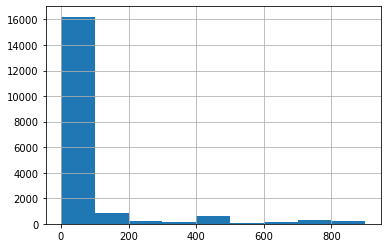

time: 164 ms


In [170]:
files_basic_stats_df['char_lengths'].hist(bins=pd.np.arange(0, 1000, 100))

Many documents, ~16,000 documents, have character lengths that is less than 100.

### Word length distribution

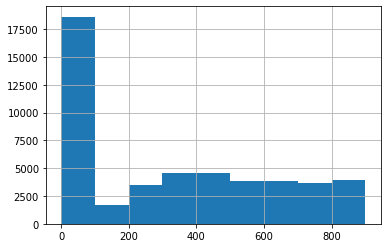

time: 150 ms


In [171]:
files_basic_stats_df['word_counts'].hist(bins=pd.np.arange(0, 1000, 100))

In [122]:
# char_lengths = []
# word_counts = []
# for txt_path in sample_files:
#     with open(txt_path, 'rb') as fl:
#         orig_text = fl.read().decode('utf-8', errors='ignore')

#         char_lengths.append(len(orig_text))
#         word_counts.append(len(orig_text.split()))
        
# wc = pd.Series(word_counts)
# cl = pd.Series(char_lengths)

# wc.hist(bins=pd.np.arange(0, 1000, 100))
# cl.hist(bins=pd.np.arange(0, 10000, 100))

time: 59.4 s


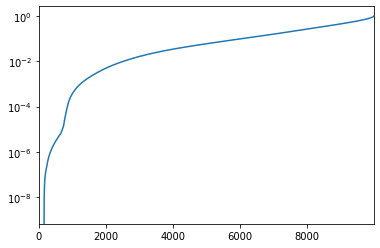

time: 196 ms


In [159]:
(cl.sort_values().cumsum() / cl.sort_values().sum()).reset_index(drop='index').plot(logy=True, logx=False)

# Perform spacy cleaning on sample files

In [9]:
from joblib import Parallel, delayed
import pymongo

time: 49.8 ms


In [10]:
mongo = pymongo.MongoClient(port=27018)
db = mongo['nlp']
collection = db['spacy-parsed']

collection.count_documents({})

7365

time: 64.4 ms


In [11]:
# de = collection.delete_many({})

time: 273 µs


In [12]:
# https://spacy.io/api/annotation
POS_TAGS = ['POS', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']


def get_doc_id(fname):
    return fname.split('/')[-1].split('.')[0]


def read_files(txt_path):
    with open(txt_path, 'rb') as fl:
        orig_text = fl.read().decode('utf-8', errors='ignore')

        text = orig_text.replace('•', '\n')
        text = white_space_normalize.sub(' ', text)  # sub with ' '
        text = normalize_citations.sub(r'\1. ', text)
        
    return text.strip()


def extract_parsed_data(doc):
    sentences = [s.text for s in doc.sents]
    lemmas = [[token.lemma_ for token in s] for s in doc.sents]
    pos = [[token.pos_ for token in s] for s in doc.sents]
    tag = [[token.tag_ for token in s] for s in doc.sents]
    num_sentences = len(sentences)
    spacy_token_count = len([i for l in lemmas for i in l])
    mean_sentence_length = np.mean([len(s) for s in sentences]) if num_sentences > 0 else 0
    pos_distribution = pd.Series(dict(Counter([i for p in pos for i in p])), index=POS_TAGS).fillna(0).astype(int).to_dict()
    
    payload = dict(
        sentences=sentences,
        lemmas=lemmas,
        pos=pos,
        tag=tag,
        num_sentences=num_sentences,
        spacy_token_count=spacy_token_count,
        mean_sentence_length=mean_sentence_length,
        pos_distribution=pos_distribution
    )
    
    return payload


def transform_doc(text, fname=None):
#     mongo = pymongo.MongoClient(port=27018)
#     db = mongo['nlp']
#     collection = db['spacy-parsed']
    
    SPACY_MAX_LENGTH = 100 * 1000000
    
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'], max_length=SPACY_MAX_LENGTH)
    doc = nlp(text.strip())

    payload = extract_parsed_data(doc)
    
    payload.update(
        dict(
            fname=fname,
            _id=get_doc_id(fname)
        )
    )
    
#     collection.replace_one({'_id': payload['_id']}, payload, upsert=True)

    return payload


def read_transform(txt_path):
    text = read_files(txt_path)
    return transform_doc(text, txt_path)


def extract_stats_from_text(text):
    payload = {}
    payload['char_length'] = len(text)
    payload['simple_split_count'] = len(text.split())
    payload['word_g1_count'] = len(alpha_g1_pattern.findall(text))
    payload['word_g2_count'] = len(alpha_g2_pattern.findall(text))
    payload['word_g3_count'] = len(alpha_g3_pattern.findall(text))
    payload['word_g4_count'] = len(alpha_g4_pattern.findall(text))
    payload['word_g5_count'] = len(alpha_g5_pattern.findall(text))
    payload['alpha_num_count'] = len(alpha_num_pattern.findall(text))

    return payload


def memory_wrapper_transform_docs(fnames):
    payloads = transform_docs(fnames)
    gc.collect()
    
    return payloads

def transform_docs(fnames):
    SPACY_MAX_LENGTH = 100 * 1000000
    
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'], max_length=SPACY_MAX_LENGTH)
    
    payloads = []
    
    for fname in fnames:
        payload = {}
        
        try:
            text = read_files(fname)
            payload.update(extract_stats_from_text(text.strip()))
            
            doc = nlp(text.strip())
            payload.update(extract_parsed_data(doc))
        except Exception as e:
            payload = dict(
                exception=f'{type(e)}: {e}'
            )

        payload.update(
            dict(fname=fname, _id=get_doc_id(fname))
        )
        payloads.append(payload)
        
    return payloads

time: 5.75 ms


https://stackoverflow.com/questions/33714678/what-batch-size-and-pre-dispatch-in-joblib-exactly-mean

In [13]:
# sq = memory_wrapper_transform_docs(shuffled_files[:25])
# time: 27.8 s

time: 326 µs


In [14]:
# sq = memory_wrapper_transform_docs(shuffled_files[:25])
# time: 33.1 s

time: 229 µs


In [13]:
# available_docs = set(i['_id'] for i in collection.find({}, projection=['_id']))
available_docs = set()  # This is used because we're not using mongodb
unprocessed_shuffled_files = [sf for sf in shuffled_files if get_doc_id(sf) not in available_docs]
len(unprocessed_shuffled_files), len(shuffled_files)

(249661, 249661)

time: 212 ms


In [14]:
%run ../path_manager.ipynb

time: 18.6 ms


In [15]:
import pickle

time: 341 µs


In [16]:
def store_batch(dataset, batch_count):
    with open(f'../../CORPUS/spacy_cleaned/spacy_cleaned_batch_{batch_count}.pickle', 'wb') as fl:
        pickle.dump(dataset, fl)

time: 597 µs


In [ ]:
from joblib import Parallel, delayed, parallel_backend
n_jobs = 75
num_docs = 25
notify_fname = 'spacy_cleaner.log'

with Parallel(n_jobs=n_jobs, batch_size=10, pre_dispatch=n_jobs) as parallel:
    # batch_size of 10 means that the process will receive 10 list of fnames.
    # pre_dispatch of 70 means that joblib will send 70 batches to the queue.
    batch = []
    batch_count = 0
    for fnames in np.array_split(unprocessed_shuffled_files, len(unprocessed_shuffled_files) // num_docs + 1):
        if len(batch) and len(batch) % (n_jobs * 2) == 0:
            batch_count += 1
            parsed_datasets = parallel(delayed(memory_wrapper_transform_docs)(fnames) for fnames in batch)
            batch = []
            parsed_datasets = [payload for parsed_dataset in parsed_datasets for payload in parsed_dataset]
            notify(notify_fname, f'Processed {len(parsed_datasets)} docs for batch {batch_count}...', verbose=True)
            store_batch(parsed_datasets, batch_count)
            # insert_result = collection.insert_many(parsed_datasets)
            notify(notify_fname, f'Stored {len(parsed_datasets)} docs for batch {batch_count}...', verbose=True)
            # notify(notify_fname, f'Stored {len(insert_result.inserted_ids)} docs for batch {batch_count}...', verbose=True)
        else:
            batch.append(fnames)

    if batch:
        batch_count += 1
        parsed_datasets = parallel(delayed(memory_wrapper_transform_docs)(fnames) for fnames in batch)
        batch = []
        parsed_datasets = [payload for parsed_dataset in parsed_datasets for payload in parsed_dataset]
        notify(notify_fname, f'Processed {len(parsed_datasets)} docs for batch {batch_count}...', verbose=True)
        store_batch(parsed_datasets, batch_count)
        # insert_result = collection.insert_many(parsed_datasets)
        notify(notify_fname, f'Stored {len(parsed_datasets)} docs for batch {batch_count}...', verbose=True)
        # notify(notify_fname, f'Stored {len(insert_result.inserted_ids)} docs for batch {batch_count}...', verbose=True)

/home/wb536061/anaconda3/envs/wb-nlp/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


2019-12-17 17:09:34.653430: Processed 3750 docs for batch 1...
2019-12-17 17:10:14.723052: Stored 3750 docs for batch 1...
2019-12-17 17:14:23.340938: Processed 3750 docs for batch 2...
2019-12-17 17:15:04.272939: Stored 3750 docs for batch 2...
2019-12-17 17:18:44.461574: Processed 3750 docs for batch 3...
2019-12-17 17:19:26.309703: Stored 3750 docs for batch 3...
2019-12-17 17:22:56.464421: Processed 3750 docs for batch 4...
2019-12-17 17:23:36.022516: Stored 3750 docs for batch 4...
2019-12-17 17:27:38.950164: Processed 3750 docs for batch 5...
2019-12-17 17:28:24.010910: Stored 3750 docs for batch 5...
2019-12-17 17:32:11.464300: Processed 3750 docs for batch 6...
2019-12-17 17:32:53.785247: Stored 3750 docs for batch 6...
2019-12-17 17:36:23.941738: Processed 3750 docs for batch 7...
2019-12-17 17:37:03.413559: Stored 3750 docs for batch 7...
2019-12-17 17:40:39.027551: Processed 3750 docs for batch 8...
2019-12-17 17:41:20.607894: Stored 3750 docs for batch 8...
2019-12-17 17:46

In [19]:
batch_count, len(parsed_datasets)

(67, 511)

time: 2.14 ms


In [ ]:
# q = read_files('../../CORPUS/WB/TXT_ORIG/wb_15321626.txt')
# [pd for pd in parsed_datasets if pd['_id'] == 'wb_15321626']  # Memory exceeded

In [20]:
len([i for i in parsed_datasets if i.get('exception') is not None])

0

time: 6.17 ms


In [22]:
5000 / (5 * 60 + 35)

14.925373134328359

time: 1.58 ms


In [26]:
parsed_datasets[0]['_id']

'wb_24837024'

time: 1.62 ms


In [27]:
collection.find({}, projection=['_id'])

time: 2 ms


In [12]:
from joblib import Parallel, delayed, parallel_backend

with Parallel(n_jobs=70, batch_size=10, pre_dispatch=70) as parallel:
    # batch_size of 10 means that the process will receive 10 list of fnames.
    # pre_dispatch of 70 means that joblib will send 70 batches to the queue.
    parsed_datasets = parallel(delayed(memory_wrapper_transform_docs)(fnames) for fnames in np.array_split(shuffled_files, len(shuffled_files) // 25 + 1)[:100])

parsed_datasets = [payload for parsed_dataset in parsed_datasets for payload in parsed_dataset]

time: 2min 46s


In [17]:
from joblib import Parallel, delayed, parallel_backend

with Parallel(n_jobs=70, batch_size=1, pre_dispatch=70) as parallel:
    # batch_size of 10 means that the process will receive 10 list of fnames.
    # pre_dispatch of 70 means that joblib will send 70 batches to the queue.
    parsed_datasets = parallel(delayed(memory_wrapper_transform_docs)(fnames) for fnames in np.array_split(shuffled_files, len(shuffled_files) // 25 + 1)[:100])

parsed_datasets = [payload for parsed_dataset in parsed_datasets for payload in parsed_dataset]

time: 2min 52s


In [16]:
from joblib import Parallel, delayed, parallel_backend

with Parallel(n_jobs=70, batch_size=20, pre_dispatch=70) as parallel:
    # batch_size of 10 means that the process will receive 10 list of fnames.
    # pre_dispatch of 70 means that joblib will send 70 batches to the queue.
    parsed_datasets = parallel(delayed(memory_wrapper_transform_docs)(fnames) for fnames in np.array_split(shuffled_files, len(shuffled_files) // 25 + 1)[:100])

parsed_datasets = [payload for parsed_dataset in parsed_datasets for payload in parsed_dataset]

time: 2min 58s


In [15]:
from joblib import Parallel, delayed, parallel_backend

with Parallel(n_jobs=70, batch_size=10, pre_dispatch=140) as parallel:
    # batch_size of 10 means that the process will receive 10 list of fnames.
    # pre_dispatch of 70 means that joblib will send 70 batches to the queue.
    parsed_datasets = parallel(delayed(memory_wrapper_transform_docs)(fnames) for fnames in np.array_split(shuffled_files, len(shuffled_files) // 25 + 1)[:100])

parsed_datasets = [payload for parsed_dataset in parsed_datasets for payload in parsed_dataset]

/home/wb536061/anaconda3/envs/wb-nlp/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


time: 2min 53s


In [13]:
len(parsed_datasets)

2500

time: 2.3 ms


In [14]:
2500 / (120 + 46)

15.060240963855422

time: 2.69 ms


In [54]:
parsed_datasets[0]['lemmas']

[['\ufeffOFFICIAL', 'DOCUMENTS', '14', '1o'],
 ['the', 'WORLD', 'BANK', 'ibrd*ida'],
 ['-PRON-',
  'world',
  'SANKOROUP',
  'Ethiopia',
  'Country',
  'Office',
  'Africa',
  'Avenue',
  ',',
  'Bole',
  'Road'],
 ['Tel', ':', '(', '251', '-', '11', ')', '5176000'],
 ['Addis',
  'Abeba',
  ',',
  'Ethiopia',
  'Fax',
  ':',
  '(',
  '251',
  '-',
  '11',
  ')',
  '6627717'],
 ['July', '23', ',', '2015'],
 ['Ref.:WB', '-', 'CD/306/07/23/2015', 'H.', 'E.', 'Ato'],
 ['Sufian',
  'Ahmed',
  'Minister',
  'Ministry',
  'of',
  'Finance',
  'and',
  'Economic',
  'Development'],
 ['Addis', 'Ababa', 'Re', ':', 'IFAD', 'Loan', 'Financing', '2000000426'],
 ['(', 'Pastoral', 'Community', 'Development', 'Project', 'III', ')'],
 ['additional', 'instruction', ':', 'Disbursement', 'Dear', 'Ato', 'Sufian'],
 [',',
  '-PRON-',
  'refer',
  'to',
  'the',
  'Financing',
  'Agreement',
  'between',
  'the',
  'International',
  'Fund',
  'for',
  'Agricultural',
  'Development',
  '(',
  'the',
  'Fund

time: 53.8 ms


In [ ]:
from joblib import Parallel, delayed, parallel_backend

# with parallel_backend('loky', inner_max_num_threads=10):
#     parsed_dataset = Parallel(n_jobs=70)(delayed(read_transform)(fname) for fname in sample_files[:100])

with Parallel(n_jobs=70, batch_size=100, pre_dispatch=70) as parallel:
    parsed_dataset = parallel(delayed(read_transform)(fname) for fname in files)

/home/wb536061/anaconda3/envs/wb-nlp/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
insert_result = collection.insert_many(parsed_dataset)

In [48]:
# delete_result = collection.delete_many({})

time: 30.2 ms


In [35]:
2 * (200000/1000) / 60

6.666666666666667

time: 1.68 ms


In [32]:
parsed_dataset[0]

{'sentences': [' Public Disclosure Copy The World Bank Implementation Status & Results Report Shandong Energy Efficiency Project (P114069)',
  'Shandong Energy Efficiency Project (P114069)',
  'EAST ASIA AND PACIFIC',
  '|',
  'China | Energy & Extractives',
  'Global Practice | IBRD/IDA | Specific Investment Loan',
  '|',
  'FY 2011 | Seq',
  'No:',
  '11 | ARCHIVED on 04-May-2017 |',
  'ISR26575 | Implementing Agencies: Key Dates Key Project Dates',
  'Bank Approval Date:09-Jun-2011 Effectiveness Date:25-Nov-2011',
  'Planned Mid Term Review Date:15-Sep-2014',
  'Actual Mid-Term Review Date:03-Nov-2014 Original Closing Date:30-Sep-2016 Revised Closing Date:31-Mar-2018 Project Development Objectives Project Development Objective (from Project Appraisal Document)',
  "The objective of the Project is to improve energy efficiency in selected enterprises in the Borrower's Shandong Province,particularly through financial leasing arrangements, and increase use of biomass for power and heat 

time: 13.8 ms


In [17]:
collection.replace_one?

time: 38.4 ms


Signature:
collection.replace_one(
    filter,
    replacement,
    upsert=False,
    bypass_document_validation=False,
    collation=None,
    session=None,
)
Docstring:
Replace a single document matching the filter.

  >>> for doc in db.test.find({}):
  ...     print(doc)
  ...
  {u'x': 1, u'_id': ObjectId('54f4c5befba5220aa4d6dee7')}
  >>> result = db.test.replace_one({'x': 1}, {'y': 1})
  >>> result.matched_count
  1
  >>> result.modified_count
  1
  >>> for doc in db.test.find({}):
  ...     print(doc)
  ...
  {u'y': 1, u'_id': ObjectId('54f4c5befba5220aa4d6dee7')}

The *upsert* option can be used to insert a new document if a matching
document does not exist.

  >>> result = db.test.replace_one({'x': 1}, {'x': 1}, True)
  >>> result.matched_count
  0
  >>> result.modified_count
  0
  >>> result.upserted_id
  ObjectId('54f11e5c8891e756a6e1abd4')
  >>> db.test.find_one({'x': 1})
  {u'x': 1, u'_id': ObjectId('54f11e5c8891e756a6e1abd4')}

:Parameters:
  - `filter`: A query that match

In [422]:
with Parallel(n_jobs=70, backend='loky') as parallel:
    parsed_dataset = parallel(delayed(transform_doc)(text, fname) for text, fname in zip(texts[:100], sample_files[:100]))

RuntimeError: can't start new thread

time: 30.5 s


In [411]:
list(map(len, parsed_dataset))

300

time: 1.51 ms


In [406]:
len(parsed_dataset)

100

time: 1.7 ms


In [415]:
parsed_dataset[0]['fname'].split('/')[-1].split('.')[0]

'wb_30609716'

time: 1.79 ms


In [414]:
fname.split('/')[-1].split('.')[0]

NameError: name 'fname' is not defined

time: 12.1 ms


In [ ]:
sentence_lengths = pd.Series([len(re.findall('[a-z]+', i.lower())) for j in d for i in j])

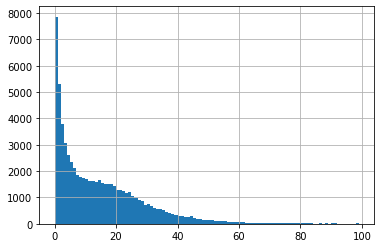

time: 570 ms


In [383]:
sentence_lengths.hist(bins=pd.np.arange(0, 100, 1))

In [389]:
# texts = []

# for txt_path in sample_files:
#     with open(txt_path, 'rb') as fl:
#         orig_text = fl.read().decode('utf-8', errors='ignore')
        
#         text = orig_text
#         text = white_space_normalize.sub(' ', text)  # sub with ' '
#         text = normalize_citations.sub(r'\1. ', text)
        
#         texts.append(text)

# len(texts)

time: 442 µs


In [105]:
def get_nlp_doc(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    
    return doc

time: 701 µs


In [175]:
os.environ['OMP_NUM_THREADS'] = "50"
os.environ['OPENBLAS_NUM_THREADS'] = '50'

time: 475 µs


In [178]:
docs = nlp.pipe(texts, batch_size=100, n_threads=50)  # , disable=['parser', 'ner', 'textcat'])

time: 790 µs


In [185]:
# for doc in docs:
#     print(len(doc))
#     # pass

time: 340 µs


In [113]:
# with pathos.multiprocessing.Pool(processes=20) as pool:
#     docs = pool.map(get_nlp_doc, texts)

# with pathos.multiprocessing.Pool(processes=50) as pool:
#     for i in pool.imap(get_nlp_doc, texts):
#         print(len(i))

time: 261 µs


In [181]:
orig_text = '''                                      Document of
                                   The World Bank

                           FOR OFFICIAL USE ONLY

                                                                      Report No: {PP1781}




                                   PROJECT PAPER

                                         ON A

                                 PROPOSED GRANT

               IN THE AMOUNT OF(US$ 0.2 MILLION EQUIVALENT)

                                        TO THE

                                 REPUBLIC OF IRAQ

                                         FOR A

                         SWIFT KRSO Kurdistan-Iraq P158493

                                    August, 8th 2016




This document has a restricted distribution and may be used by recipients only in the
performance of their official duties. Its contents may not otherwise be disclosed without
World Bank authorization.
                          CURRENCY EQUIVALENTS

                         (Exchange Rate Effective {Date})




                                  FISCAL YEAR
                             January 1 – December 31

                    ABBREVIATIONS AND ACRONYMS
KRSO    Kurdistan Region Statistics Office
IHSES   Iraq Household and Socio Economic Survey
GoI     Government of Iraq




               Regional Vice President:     Hafez M. H. Ghanem
                      Country Director:     Ferid Belhaj
        Global Practice Senior Director:    Ana L. Revenga
                      Practice Manager:     Benu Bidani
                    Task Team Leader:       Nandini Krishnan/Sergio Daniel Olivieri
                                             COUNTRY
                                   SWIFT KRSO Kurdistan-Iraq (P158493)

                                                TABLE OF CONTENTS

                                                                                                                                      Page

I.     STRATEGIC CONTEXT .................................................................................................7
       A. Country Context ............................................................................................................ 7
       B. Sectoral and Institutional Context ................................................................................. 7
       C. Higher Level Objectives to which the Project Contributes .......................................... 8

II.    PROJECT DEVELOPMENT OBJECTIVES ................................................................9
       A. PDO............................................................................................................................... 9
       Project Beneficiaries ........................................................................................................... 9
       PDO Level Results Indicators ............................................................................................. 9

III.   PROJECT DESCRIPTION ..............................................................................................9
       A. Project Components ...................................................................................................... 9
       B. Project Cost and Financing ......................................................................................... 10

IV.    IMPLEMENTATION .....................................................................................................10
       A. Institutional and Implementation Arrangements ........................................................ 10
       B. Results Monitoring and Evaluation ............................................................................ 11
       C. Sustainability (if applicable) ....................................................................................... 11

V.     KEY RISKS AND MITIGATION MEASURES ..........................................................11

VI.    APPRAISAL SUMMARY ..............................................................................................12
       Please provide one paragraph with a summary description of the main economic benefits
           and costs of the project and a second paragraph summarizing the key FM,
           procurement and safeguards issues. ............................................................................ 12
       A. Other Safeguards Policies Triggered .......................................................................... 12
       B. World Bank Grievance Redress .................................................................................. 12
                                                                    DATA SHEET
                                                                           Iraq
                                                    SWIFT KRSO Kurdistan-Iraq (P158493)
                                                     Small RETF Grant Project Paper
.




                                                    MIDDLE EAST AND NORTH AFFRICA
                                                                        GPVDR

.




                                                                Basic Information
Date:                            January 20, 2016                   Sectors:          Poverty
Country Director:                Ferid Belhaj                       Themes:           Social protection and risk management

Practice Manager/Global            Benu Bidani / Ana L. Revenga     EA Category:      C-Not Required
Practice Senior Director:
Project ID:                      P158493
Instrument:                      Investment Project Financing
Team Leader(s):                  Nandini Krishnan / Sergio Daniel
                                 Olivieri

.




Recipient: Republic of Iraq
Executing Agency: Kurdistan Region Statistical Office
    Contact:             Mr Serwan Mohamed                                        Title:        President, Kurdistan Region Statistic Office
    Telephone No.:       9647504451327                                            Email:        serwan.mohamed@krso.net
.




Project Implementation Period:             Start Date:   01-Jul-2016               End Date:    31-Dec-2016
Expected Effectiveness Date:

Expected Closing Date:                  31-Jul-2017
.




                                                         Project Financing Data(US$M)
Total Project Cost :                                     0.2                   Total Financing :                              0.2
Financing Gap :
.




Financing Source                                                                                                                Amount(US$M)
BORROWER/RECIPIENT                                                                                                                        0.00

Trust Fund for Statistical Capacity Building                                                                                              0.20

Financing Gap                                                                                                                             0.00
Total                                                                                                                                     0.20
.




Expected Disbursements (in USD Million)
Fiscal Year     2016             2017
Annual          0.01             0.19
Cumulative      0.01             0.20
.
Project Development Objective(s)
The PDO of this grant is to support the Kurdistan Region Statistics Office of the Government of Iraq in collecting
and analyzing a SWIFT survey for poverty monitoring in 2016 in Erbil, Duhok and Sulaimaniya.
.




Components
Component Name                                                                                                       Cost (USD Millions)

Support the KRSO in preparing and implementing a SWIFT                                                                                  0.20

for poverty monitoring in 2016

.




                                                                     Compliance
Policy
Does the project depart from the CAS /CPS/CPF in content or in other significant respects?                     Yes [ ]         No [X]
.




Does the project require any exceptions from Bank policies?                                                    Yes [ ]         No [X]
Have these been approved by Bank management?                                                                   Yes [ ]         No [X]
Is approval for any policy exception sought from the Board?                                                    Yes [ ]         No [X]
Does the project meet the Regional criteria for readiness for implementation?                                  Yes [X]         No [ ]
.




Safeguard Policies Triggered by the Project                                                                    Yes              No
Environmental Assessment OP/BP 4.01                                                                                             X
Natural Habitats OP/BP 4.04                                                                                                     X
Forests OP/BP 4.36                                                                                                              X

Pest Management OP 4.09                                                                                                         X

Physical Cultural Resources OP/BP 4.11                                                                                          X
Indigenous Peoples OP/BP 4.10                                                                                                   X

Involuntary Resettlement OP/BP 4.12                                                                                             X
Safety of Dams OP/BP 4.37                                                                                                       X

Projects on International Waters OP/BP 7.50                                                                                     X

Projects in Disputed Areas OP/BP 7.60                                                                                           X
.




Legal Covenants
Name                                                           Recurrent                     Due Date           Frequency


Description of Covenant


.




                                                                  Team Composition
Bank Staff
Name                                    Title                                   Specialization          Unit             UPI
Nandini Krishnan               Team Leader (ADM            Senior Economist                  GPV05      292876
                               Responsible)
Sergio Daniel Olivieri         Team Leader                 Senior Economist                  GPV05      316966
Nazaneen Ismail Ali            Procurement Specialist      Senior Procurement                GGO05      275389
                               (ADM Responsible)           Specialist
Jad Raji Mazahreh              Financial Management        Sr Financial Management           GGO23      334086
                               Specialist                  Specialist
Cornelia Mirela Catuneanu Team Member                      Program Analyst                   GPV06      152088
Dhiraj Sharma                  Team Member                 Young Professional                GPV05      425117
Nobuo Yoshida                  Team Member                 Senior Economist                  GPV06      236343
Saba Nabeel M Gheshan          Counsel                     Counsel                           LEGAM      483769
Shingira Samantha              Counsel                     Counsel                           LEGAM      455014
Masanzu
Vidya Narasimhan               Team Member                 Finance Officer                   WFALN      255977
Non Bank Staff
Name                           Title                       Office Phone                      City


.




Locations
Country                  First Administrative   Location                  Planned   Actual   Comments
                         Division


.
I.   STRATEGIC CONTEXT

     A. Country Context

 1.       Iraq plunged into two simultaneous crises in the second half of 2014, one driven by the Islamic
 State insurgency, the other, by a sharp decline in oil prices. Since June 2014, crude oil prices per barrel
 have fallen from around 112 USD to 97 USD in September and 62 USD by December 2014. Given Iraq’s
 heavy dependence on oil as a share of GDP and exports, and a source of government revenues, this decline
 in prices alone would have hit Iraq’s fragile economy hard.
 2.      In addition, since June 2014, Islamic State militants extended their influence from Syria into
 Iraq’s northern and western provinces of Anbar, Nineveh, Salahadin, and to a lesser e xtent, Kirkuk and
 Diyala. A total of 354,000 families were internally displaced between June and December of 2014 which
 represents about 2.1 million individuals; and those left behind have been cut off from the rest of the
 country. Civilian casualties in Iraq have increased to close to 2007 levels (Iraq Body Count) as a result
 of the ongoing violence.
 3.       The bulk of the forced displacement of people took place in the five IS-affected governorates,
 with Anbar, Salahadin and Nineveh alone accounting for 90 percent of the displaced families. These
 internally displaced persons (IDPs) have sought refuge across Iraq – 63 percent of IDPs have crossed into
 other governorates, about half of them into the three governorates of Iraqi Kurdistan.
 4.        Both crises are likely to have had significant adverse impacts on the economy and the welfare
 of Iraqis, through different channels. The prevailing insecurity has disrupted oil exports from the north,
 adversely impacted trade and investment, led to the destruction of infrastructure and impeded the flow of
 goods and services across the country, leading to a sharp contraction in oil and non-oil GDP (World Bank,
 Iraq Macro-Poverty Outlook, Spring 2015). The accompanying decline in public spending on social
 services and government transfers, and employment and earnings has likely affected the welfare of Iraqis
 across the distribution. In addition, the population of the governorates directly affected by the Islamic
 State insurgency has suffered substantial disruptions in their livelihoods and incomes; as well as a loss of
 durable assets; not to mention the loss of life.
 5.       Results from an ex-ante assessment of the crises show an almost complete erosion of the welfare
 gains of the past, with poverty falling back to 2007 levels and a 20% increase in the number of the poor.
 While the incidence of poverty is higher among Internal Displaced Population (IDP) than the rest of the
 population everywhere except in the Islamic State-affected governorates, IDPs make up only a small
 proportion of Iraq’s 8 million poor in 2014. The rest comprise of households who already lived below the
 poverty line, or those who have fallen below the poverty line in the face of the massive economic
 disruptions the country is facing. The welfare impact of the crises varies widely across space, with the
 largest increases in headcount rates in Kurdistan and the IS-affected governorates. Yet, the poorest
 regions in the 2014 crisis scenario are the same as in 2012 – the currently IS-affected, and the South, with
 poverty rates of 40 % and 30% respectively.


     B. Sectoral and Institutional Context

 6.       The recurrent and often violent crises in Iraq pose a severe challenge to monitoring poverty and
 welfare, precisely at times when and in a context where, it is most critical. The 2007 Iraq Household and
 Socio-Economic Survey (IHSES) was the first comprehensive socio-economic survey in Iraq after a gap
 of nearly two decades. It was also the basis for the first estimates and analysis of poverty in line with
 international standards. The 2012 IHSES allowed for the analysis and estimation of poverty trends and a
 range of socio-economic indicators covering a period of relative peace and stability. These very large and
 comprehensive surveys are implemented roughly every five years, because of the costs of the survey in
 terms of budget but also in terms of logistical preparations and personnel.
7.       In order to get more frequent poverty estimates in-between IHSES years, the Central Statistics
Office (CSO) and the Kurdistan Region Statistics Office fielded the Continuous Household Survey (CHS)
in 2014. The CHS surveys a sub-sample of IHSES clusters or PSUs, and contains a subset of IHSES
modules. In particular, key modules for the construction of a comparable welfare aggregate were identical
to the IHSES – the household roster, education modules, modules on labor market outcomes, food and
non-food consumption expenditures, consumption and expenditures on rations or PDS items, and
incomes from earnings and public and private transfers. Fieldwork began in November 2013 and was
supposed to run for 12 months. The intended sample of 13,834 households was drawn to be representative
at the governorate level.
8.      Fieldwork and data collection for the 2014 CHS was disrupted in May 2014 due to the
deteriorating security situation in some areas and the growing influence of Islamic State (IS) militants in
the northwest of the country. As a result, in five governorates, fieldwork could not be completed as
planned – Nineveh, Anbar, Salahadin, Kirkuk and Baghdad. In Baghdad the last quarter was severely
affected in terms of response rates, and no household in rural Baghdad could be interviewed. In the
remaining 13 governorates, fieldwork continued as planned.
9.       As a result, national level estimates of poverty using the CHS 2014 could not be estimated. The
World Bank is supporting the Iraqi and Kurdistan region statistical offices in estimating poverty estimates
for the 13 governorates where fieldwork was completed. The results suggest that Iraq had made
remarkable progress towards poverty reduction in the first half of the year, with poverty headcount rates
falling 5 percentage points relative to the first half of 2012. It is reasonable, as suggested by the micro-
simulation estimates, that these welfare gains were eroded by the end of the year.
10.      The crises do not appear to be short-lived, and the welfare situation is likely deteriorating further.
The ongoing security and budget crisis imply that large household surveys are not feasible in the near
future. The next IHSES planned for 2017 is unlikely to take place on time. At the same time, it is more
important than ever to monitor poverty and key socio-economic indicators, given the scale of the crises,
and the high concentration of the population close to the poverty line.
11.      It is also important to recognize that the Iraqi statistical offices have made remarkable progress
in the last decade. There have been significant improvements in capacity evidenced by the high quality
of the two IHSES surveys, and the in-depth analytical work, including two poverty assessments and a
poverty map. In addition, the statistical offices made every effort to try and complete the 2014 CHS as
far as feasible given the security situation. Finally, the CSO and KRSO are both committed to open access
to data – both the IHSES surveys are currently available for public use through the World Bank’s LSMS
survey database.


    C. Higher Level Objectives to which the Project Contributes

12.      The SWIFT is an innovative new tool developed by the World Bank to provide high frequency
poverty estimates. However, the challenges posed by the Iraqi context imply that the exercise will require
learning and adaptation. If successful, the CSO and KRSO plan to regularly incorporate SWIFT into their
system of surveys once the model had been finalized based on the next nationwide IHSES survey. The
2016 SWIFT exercise aims to provide a quick snapshot of the welfare situation for policy action, with
the understanding that the crisis situation poses several challenges for modeling and comparability with
the relatively “normal” years of 2007 and 2012. Moreover, this exercise will be limited by the security
situation. It is likely that the governorates of Anbar, Nineveh and Salahadin may not be covered by this
survey.
II.    PROJECT DEVELOPMENT OBJECTIVES

       A. PDO


 13.     The PDO of this grant is to support the Kurdistan Region Statistics Office of the Government of
 Iraq in implementing and analyzing a SWIFT for poverty monitoring in 2016 in three selected
 governorates: Erbil, Duhok and Sulaimaniya. SWIFT is a short, tablet based survey that estimates poverty
 headcount rates based on a modeling exercise using most recently available household survey data.

       Project Beneficiaries

 14.      The beneficiary of this Project is the Ministry of Planning from Government of Kurdistan Region.

       PDO Level Results Indicators

 15.     The key result that is expected from the Project is to reduce time for tracking the incidence of
 poverty in Iraq between years when comprehensive and extensive household surveys are collected like
 IHSES. These results will be only possible to obtain for those governorates covered by the survey. A
 methodological note of the SWIFT model(s) implemented in this project is also an important output.
 16.      Intermediate outputs include:
              (a) Development of SWIFT platform
              (b) Development of SWIFT model(s) for governorates covered by the survey
              (c) Generation of SWIFT dataset after data collection for analysis of results
              (d) Capacity building of KRSO staff on implementing SWIFT
 17.     Data quality and accessibility: it is important to acknowledge that the Iraqi statistical offices (i.e.
 CSO and KRSO) have made remarkable progress over the last decades. As above mentioned, there have
 been not only significant improvements in capacity evidenced by the high quality of the two IHSES
 surveys which has allowed in-depth analytical work, but also both statistics offices have committed to
 open access to data – both rounds of the IHSES are currently available for public use through the World
 Bank’s LSMS database

III. PROJECT DESCRIPTION

       A. Project Components

 18.     There is only one component of the proposed project which is the implementation of the SWIFT
 survey for poverty monitoring in 2016. SWIFT is the acronym for Survey of Well-Being via Instant,
 Frequent Tracking (SWIFT) which is a new household survey instrument that projects consumption based
 on collecting 10 to 15 simple questions on poverty correlates such as education of the household head,
 ownership of consumer durables, household head’s employment status, among others. The main
 advantages of using SWIFT are saving time and reducing survey implementation costs.
 19.     The set of activities financed by this grant includes from survey preparation and design, up-to
 data processing and dissemination. This grant will also be used for purchasing some goods KRSO requires
 to conduct this survey. Note that the amount allocated for the latter is less than 20% of the total grant.
 20.      Fieldwork is planned for the second half of 2016 in all governorates where feasible due to security
 constraints. This will likely exclude the three governorates currently under the influence of the Islamic
 State, unless the security situation improves significantly.
     B. Project Cost and Financing

 21.    The lending instrument will be Investment Project Financing (IPF), financed with a Recipient
 Executed Trust Fund for Statistics Capacity Building (TFSCB) at the amount of US$ 200,000. The World
 Bank support is planned for 2016.

                    Project Components                  Project cost   Grant Financing    % Financing
       Implementing SWIFT 2016:                             200,000           200,000          100
          1.Survey preparation and design                    71,720            71,720          100
          2.Survey implementation and data collection        66,400            66,400          100
          3.Data processing and dissemination                13,780            13,780          100
          4.Goods                                            20,000            20,000          100
          5. Other                                           28,100            28,100          100

       Total Baseline Costs                                 200,000          200,000




IV. IMPLEMENTATION

     A. Institutional and Implementation Arrangements

 22.     The Kurdistan Region Statistical Office is the implementing agency of the proposed grant.
 KRSO, under the Ministry of Planning, has not implemented a World Bank grant before. Grant-specific
 financial management and procurement training will be needed to provide additional fiduciary safeguards
 and support.
 23.     The Project Management Office (PMO) will be located in the Directorate of Administration and
 Finance of KRSO and will be responsible for the day-to-day management of the project. The team will
 include staff from KRSO and consultants.

 Procurement:
 24.      Procurement under the project will be carried out in accordance with the 'Guidelines On
 Preventing and Combating Fraud and Corruption in Projects Financed by IBRD Loans and IDA Credits
 and Grants’ known as the ‘2006 Anti-Corruption Guidelines’, purchase of Goods and Works will follow
 Section I of the World Bank guidelines ‘Procurement under IBRD Loans and IDA Credits’ dated January
 2011, revised in July 2014, and Section I & V of the Guidelines ‘Selection and Employment of
 Consultants by World Bank Borrowers’ dated January 2011, revised in July 2014,; and the provisions
 stipulated in the Grant Agreement;
 25.      Procurement of Goods: the project will finance relatively small quantities of goods such as:
 software, office equipment, etc. The procurement will also be done using shopping procedures included
 in the Iraq Master Implementation Manual (MIM) or follow shopping procedures induced in the
 .country’s budget law.
 26.     Selection of Consultants: Consultants services procured under this project will mainly cover
 selection of individual Consultants that will be done in conformity with Section V of the Guidelines:
 Selection and Employment of Consultants by World Bank Borrowers
 27.     Based on the KRSO’s needs a simplified procurement plan was developed during the preparation
 of the projects using shopping method for procurement of goods and selection of individuals for
 consultancy services. It is expected that all contracts will be of small value range between US$5,000 to
 35,000 and procurement activities will be subject to post review
 28.     The Bank conducted a simplified procurement assessment through exchanges of correspondences
 between the Bank and the Counterpart representatives and interview through Bank’s local consultant in
 Erbil. Based on the overall assessment of the implementing agency and the information available on the
 environment of procurement in Iraq, the overall procurement risk is judged to be substantial which
 therefore requires the assignment of qualified procurement officer to handle the procurement activities
 financed by the projects.
 Financial Management
 29.      The Bank’s team undertook an assessment of the financial management systems within KRSO
 under the Ministry of Planning, remotely, through questionnaires and data collection. The assessment
 concluded that with the implementation of agreed-upon actions, the proposed FM arrangements will
 satisfy the minimum requirements under OP/BP10.00. Based on the results of the assessment, the overall
 FM risk is “High”. With mitigation measures in place, the project will have ac ceptable project FM
 arrangements and its FM risk rating will be “Substantial”. The FM risk is assessed as “High” mainly due
 to: a) limited capacity at KRSO to meet the Project’s financial management requirements, b) overall
 weaknesses and shortcomings in the control environment; c) limited accounting and reporting systems in
 providing timely and comprehensive information.
     B. Results Monitoring and Evaluation

 30.      The recipient shall monitoring and evaluate the progress of the Project and prepare Project
 Reports in accordance with the provisions of Section 2.06 of the Standard Conditions and on the basis of
 the indicators set in Annex 1.


     C. Sustainability (if applicable)

 31.     The WB team has requested Bank Budget support for technical assistance throughout the project
 duration (June 2016 – July 2017). Technical assistance for the FY16 duration of the project is covered
 through an ongoing TA (P154864).


V.   KEY RISKS AND MITIGATION MEASURES

 32.     An overall risk of the Project is moderate. The security situation will determine the geographic
 scope of the survey. However, the pilot, which has been completed, tested the modalities in the relatively
 insecure parts of rural Baghdad, with some success. As with the CHS 2014, the security of the field teams
 will not be compromised. The CSO and KRSO face security risks on a daily basis and have developed
 protocols over the last decades to accurately judge and mitigate these risks. These and more abundant
 precautions will be followed with safety and security being the most important element in the decision to
 undertake fieldwork in any area. SWIFT significantly reduces the risk of exposure to an insecure situation
 as each interview takes no more than 10 to 15 minutes relative to the IHSES surveys that take 4 visits of
 an hour each over three months.
 33.      One of the key assumptions of survey-to-survey imputation methodology is the stability of
 coefficients, i.e., the point estimates do not change over time. Although preliminary results from the
 Baghdad pilot are encouraging, the accuracy of projection is an empirical matter and may very well give
 implausible results in the rest of the country. Being cognizant of these risks, the team will carry out the
 modeling carefully ensuring its robustness. The team is exploring additional data sources like incidence
 of conflict to better explain transitory variations in household expenditure. In addition, the team will work
 with senior experts to adapt the SWIFT technique to these types of conflict affected contexts.
VI. APPRAISAL SUMMARY

 Please provide one paragraph with a summary description of the main economic benefits
 and costs of the project and a second paragraph summarizing the key FM, procurement
 and safeguards issues.
 Procurement:
 34.      The overall responsibility for implementation of procurement lies with the KRSO. They will be
 responsible for the implementation of activities pertaining to their jurisdiction and the day-to-day follow
 up which includes procurement processes, contract management, and reporting. The project will mainly
 cover procurement of 40 SWIFT tablets and training field workers. It will also cover some office furniture
 and equipment. In addition, the project will finance hiring of few individuals’ consultants and auditing
 firm. For procurement carried out through shopping procedures relevant procurement forms are included
 in the Iraq master implementation manual to be used.
 Financial Management
 35.      Taking into consideration the project’s activities and identified risks, project FM arrangements
 will include the following: i) centralized FM functions within the PMO, with a Financial Officer seconded
 from KRSO own staff to follow on project’s FM and disbursement issues, ii) a Designated Account (DA)
 will be opened to receive the grant proceeds, iii) excel sheets will be used to record financial transactions
 and generate the semiannual financial reports and annual financial statements, vi) submit semiannual
 financial reports to cater for project’s reporting needs, and vii) an independent external auditor, acceptable
 to the World Bank, will be appointed to audit the project’s accounts. Due to the fact that KRSO lacks
 prior experience with World Bank financed projects, continuous support and training will be provided by
 the World Bank team to the Financial Officer.


       A. Other Safeguards Policies Triggered

 36.      The project does not trigger any other safeguards policies

       B. World Bank Grievance Redress

 37.     Communities and individuals who believe that they are adversely affected by a World Bank (WB)
 supported project may submit complaints to existing project-level grievance redress mechanisms or the
 WB’s Grievance Redress Service (GRS). The GRS ensures that complaints received are promptly
 reviewed in order to address project-related concerns. Project affected communities and individuals may
 submit their complaint to the WB’s independent Inspection Panel which determines whether harm
 occurred, or could occur, as a result of WB non-compliance with its policies and procedures. Complaints
 may be submitted at any time after concerns have been brought directly to the World Bank's attention,
 and Bank Management has been given an opportunity to respond. For information on how to submit
 complaints to the World Bank’s corporate Grievance Redress Service (GRS), please visit
 http://www.worldbank.org/GRS.For information on how to submit complaints to the World Bank
 Inspection Panel, please visit www.inspectionpanel.org.
                                                                                Annex 1: Results Framework and Monitoring
                                                                               Iraq: SWIFT KRSO Kurdistan-Iraq (P158493)
Project Development Objective (PDO): The PDO of this grant is to support the Kurdistan Region Statistics Office of the Government of Iraq in collecting and analyzing a SWIFT survey for poverty monitoring
in 2016 in Erbil, Duhok and Sulaimaniya.
                                                                            Cumulative Target Values**                                                          Responsibili      Description (indicator


                                    Core
                                          Unit of                                                                                            Data Source/
 PDO Level Results Indicators*                     Baseline                                                                Frequency                             ty for Data          definition etc.)
                                         Measure                    2016        YR 2     YR3        YR 4        YR5                          Methodology
                                                                                                                                                                 Collection
Indicator One: Poverty                   Number   0 (zero)       1                                                       Annual            IHSES 2012/2014      KRSO team      The indicator measures the
Monitoring                                                                                                                                                                     incidence on poverty annually
                                                                                                                                                                                  for those governorates covered
                                                                                                                                                                                  by the survey.
Indicator Two: Methodology                 Yes/No       No           Yes                                                   Annual           IHSES 2012/14           KRSO team     Methodological report
Note                                                                                                                                                                              describing the model used for
                                                                                                                                                                                  SWIFT

                                                                         INTERMEDIATE RESULTS

Intermediate Result (Component One):

Intermediate Result indicator              Yes/No       No           Yes                                                   Annual           SWIFT model             KRSO          This indicates whether KRSO
One: SWIFT Platform                                                                                                                                                               has been able to develop this
                                                                                                                                                                                  platform
Intermediate Result indicator              Yes/No       No           Yes                                                   Annual           SWIFT model             KRSO          This indicates whether KRSO
Two: SWIFT model                                                                                                                                                                  has been able to develop the
                                                                                                                                                                                  estimation model for SWIFT
Intermediate Result indicator              Yes/No       No           Yes                                                   Annual           SWIFT model             KRSO          This indicates whether KRSO
Two: SWIFT database                                                                                                                                                               has been able to collect the
                                                                                                                                                                                  database for SWIFT
Intermediate Result indicator              Number       No           2                                                     One-time         Staff training record   KRSO - team   Number of KRSO staff trained
Four: Number of key technical                                                                                                                                                     for SWIFT design
staff trained

                                                    *Please indicate whether the indicator is a Core Sector Indicator (see further http://coreindicators)
                                                      **Target values should be entered for the years data will be available, not necessarily annually




                                                                                                    13
                                                                                                                          ANNEX 2
                                   SIMPLIFIED PROCUREMENT AND SUPERVISION PLAN
Name and contact information of the grant recipient responsible for procurement:

Contact Person: Omar Tahir Azizz
Address: KRG - Kurdistan Region Statistics Office- Kirkuk main Road
City: Erbil
Country: Iraq
Telephone No.: 009647504535542 or 00964662576846
Electronic mail address: omer.tahir@krso.gov.krd

Procurement/Supervision Plan

   1.   During preparation the Implementing Agency (IA) records the planned procurement activities in Table 1 and during
        Implementation; the IA records the actual Procurement activities that took place during the review period in the same table. If
        so agreed, the IA may use this table to confirm that the agreed procurement procedures for the grant were adhered to. At a
        minimum, those procurements for which the IA has indicated that it was not able to follow the procedures will be post reviewed.




                                                                 14
      Proc.                Description                  Estim.   Procureme    Estimated                  Comments
      Type                                               Cost    nt Method    Contract
                                                         USD                    Date
Goods         Procurement of SWIFT Tablets for          12000     Shopping   01/06/2016   Note: The 6 teams (2 team per gov. ) will
              six field teams:                                                            be working subsequently 32 days
              First Team 01 = Erbil × (4
              Interviewer + 1 Head) (SWIFT
              tablets=5)
              Second Team 02 = Erbil × (4
              Interviewer + 1 Head) (SWIFT
              tablets=5)
              Third Team 03 = Sulimany × (4
              Interviewer + 1 Head) (SWIFT
              tablets=5)
              Fourth Team 04 = Sulimany × (4
              Interviewer + 1 Head) (SWIFT
              tablets=5)
              Fifth Team 05 = Duhok × (4
              Interviewer + 1 Head) (SWIFT
              tablets=5)
              Sixth Team 06 = Duhok × (4
              Interviewer + 1 Head) (SWIFT
              tablets=5)
              KRSO team= 1 head quarter + 3
              Supervisor of Data Entry + 1 IT
              (SWIFT tablets=5)
              Spare tablets=5
              Total Tablet Number= 40


Training      Swift Training for 51 Field workers for   20400     Services   10/07/2016   51 fieldworkers -team x 5 days x $80 ($50
 services     5 days in Erbil, Sulimania and Duhok                contract                for hotel + $20 per diem + 10$
              Include IDP’s In camps and all related                                      transportation ) =20400
              field work staff s.
              Swift Training venue including (lunch     4000      Services   01/07/2016   1 venue x 5 days x 800$
              and coffee break)                                   contract



                                                                 15
consulting         Consulting services for field work         15000        IC      01/06/2016
 services (firm)
consulting         External Auditor                           5000         LCS     01/10/2016
 services(firm)
Others             1-SWIFT two cards for (phone &            2400      Operating   01/08/2016   1 card of mobile at $20 for top management
(operating cost)   internet) / month for field workers and               cost                   team and other staff (60 persons).
                   supervisors:                                                                 1 card for internet at $30 (30 field workers)
                   2- SWIFT Preparing & Printing
                   manual                                    500
                   3- SWIFT updating Sample team of                                             33 enumerators (4 in each governorate) x
                   30 enumerators (4 in each governorate)    27720                              $60 (for transport) x 14 days
                   for 14 days + 3 local supervisors
                   Computerizing of sample frame                                                6 data entry persons (2 in each governorate)
                   (listing )                                2100                               x $25 (for per diem ) x 14 days

                   4- Swift Field work:                                                                         6*(5) *32*60
                   There are two teams per governorate
                   and each team has 4 interviewers + one
                   team leader. Each interviewer has to
                   visit 16 household per day in three       57600
                   different days. Including IDP’s field
                   workers(2 person per Gov.)
                   Team numbers: Kurdistan 3 Govs
                   and 2 team =6 team
                   Team member=5
                   Days’ work=32
                   Transportation =60 US $ per day

                   5-Survey Coordinator (site visit of one                                      1person x 7 days x $140 (hotel+
                   person for 7-day stay):                   980                                transportation+ per diem)

                   6-Survey Coordinator from KRSO of                                            1 person x 25 days x $40 (per diem)
                   one supervisor for 32 days:               1000
                   (supervising survey)
                   7- SWIFT Site visits of 4 supervisors                                        4 persons x 10 days x $120 ($50 for hotel +
                   for 10 days                               4800                               $20 for per diem+ transportation 50$)


                                                                      16
             8- SWIFT Local supervisors per diem                                       3 local supervisors x 32 days x $30 (for per
             for 32 days                              2880                             diem)
             9- SWIFT Local transport for 3                                            3 local supervisors x 8 days x $30 (for
             supervisors for 8 days                   720                              transport)
             9- SWIFT Data Management team                                             1 person x 15 days x $100 ($60 for hotel +
             follow-up of one person for 15 days:     1500                             $20 for per diem + 20$ transportation)
             (site visit overnight stay)
             10- SWIFT Data Management team                                             3 persons x 32 days x $30 for per diem)
             follow-up of 3 persons for 15 days       2880
             11- SWIFT IT team                                                          4 persons x 20days x $30 (per diem)
                                                      2400
             12- SWIFT IT team follow-up site                                          4 person x 10 days x $100 ($60 for hotel +
             visits of 4 persons for 15-day stay                                       $20 for per diem + 20$ transportation)
                                                      4000
             12- Steering committee of swift for 32
             days                                     8000
             13- Administration and finance at        6750                             15 persons x 15 days x $30
             KRSO and All Governorates of 15
             persons for 10 days
             14- Administration and finance at        7500                             15 persons x 5 days x $100 (for hotel and
             KRSO and All Governorates of 15                                           Transportation)
             persons for 5 days
             15- KRSO president as Project            2500
             Supervisor
             16-Contingeny                            7370                                        Approximately % 4


2.   Describe additional supervision arrangements for the grant:
     - Supervision of the project shall be undertaken by the KRSO president.
     - If the Grant is processed through the MOF, supervision arrangements will be applied by them.




                                                             17
Status of Risk Mitigating Actions

3.     In the Table below, the Agency records the status of implementation of the mitigating actions that were agreed to following the
       Procurement Risk Assessment.

     Mitigating Action                                                              Status of Implementation

     1. Forming price- control committees to control the work of purchasing         The purchasing shall be done through dedicated
        committees and recommend approval of the prices.                            committee inside KRSO in accordance with MOF
                                                                                    regulations.
     2. Forming inspection committees to receive the goods.                         The inspection of purchased Goods will be done by
                                                                                    dedicated committee within KRSO.
     3. Keep contracts small under MOF current regulations.                         All contracts shall be procured within KRSO office for
                                                                                    all employed staffs in accordance with MOF
                                                                                    regulations.
     4. WB local staff hands-out                                                    KRSO shall report to the TTL in relation to the
                                                                                    assistance provided by local WB team.

'''

time: 5.04 ms


In [266]:
tokenizer = nlp.Defaults.create_tokenizer(nlp)

time: 103 ms


In [275]:
%%time
text = orig_text
text = white_space_normalize.sub(' ', text)  # sub with ' '
text = normalize_citations.sub(r'\1. ', text)
doc = nlp(text)  # , disable=['ner', 'textcat', 'parser'])

CPU times: user 544 ms, sys: 4.23 ms, total: 549 ms
Wall time: 547 ms
time: 548 ms


In [63]:
# line = ''
# for token in doc:
#     if not token.is_sent_start:
#         line += ' ' + str(token)  # .lemma_)
#     else:
#         print(line)
#         line = '\n'
#         line += ' ' + str(token)  # .lemma_)
#     # print(token, token.lemma_)

time: 309 µs


In [ ]:
s = list(doc.sents)

time: 110 ms


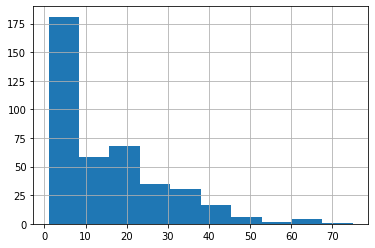

time: 240 ms


In [265]:
tokens = list(tokenizer.pipe([i.text for i in s]))
pd.Series([len(t) for t in tokens]).hist()

In [224]:
import importlib as imp

time: 481 µs


In [227]:
from bert_serving import client

time: 377 µs


In [245]:
bc = client.BertClient()

time: 103 ms


In [297]:
sentences = [i.text.strip() for i in s]

time: 7.09 ms


In [287]:
bert_encodes = bc.encode(sentences, show_tokens=False)

/home/wb536061/anaconda3/envs/wb-nlp/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


time: 1.08 s


In [325]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

time: 548 µs


In [349]:
query_vec = bc.encode(['Predicting with machine learning.'])

time: 16 ms


In [350]:
cosine_similarity(query_vec, bert_encodes).argsort()[0][::-1][:10]

array([290, 236, 156, 278, 178, 165, 284, 233, 213, 296])

time: 19.4 ms


In [296]:
pd.DataFrame(list(bert_encodes)).to_csv('doc_vec_bert.tsv', sep='\t', index=None, header=None)

time: 521 ms


In [358]:
sentences[222]

'Technical assistance for the FY16 duration of the project is covered through an ongoing TA (P154864).'

time: 1.44 ms


In [368]:
with Parallel(n_jobs=20) as parallel:
    d = parallel(delayed(transform_doc)(text) for text in texts)

time: 47.2 s


In [242]:
for i in nlp.pipe([i.text for i in s]):
    break

time: 574 ms


In [244]:
for j in i:
    print(j.lemma_)

 
Document
of
the
World
Bank
for
official
USE
ONLY
report
time: 875 µs


In [384]:
# line = ''
# for token in doc:
#     if not token.is_sent_start:
#         line += ' ' + str(token)
#     else:
#         print(line)
#         line = '\n'
#         line += ' ' + str(token)
#     # print(token, token.lemma_)

time: 351 µs


# Get entities

In [172]:
ent = ''
l = ''
for token in doc:
    if token.ent_type_:
        if token.ent_iob_ == 'I':
            ent += ' ' + str(token)
        else:
            print(ent)
            ent = f'{token.ent_type_}:'
            ent += ' ' + str(token)
#     else:
#         l += ' ' + str(token)
# print(l)


ORG: The World Bank FOR
CARDINAL: 21759
MONEY: US$ 150 MILLION
GPE: THE REPUBLIC OF POLAND FOR
DATE: February 2 , 2001
LOC: Europe
LOC: Central Asia Region
ORG: World Bank
DATE: November 2000
ORG: Currency
PERSON: Zloty
CARDINAL: 1
MONEY: US$ 0.220 US$
ORG: PLN
CARDINAL: 4.55
DATE: December 31
DATE: Annual
ORG: EU European Union
ORG: Return GDDP
ORG: General Directorate of Public Roads
ORG: Gross National Product GOP
GPE: Poland
ORG: International Competitive Bidding MIS Management Information System MTME
ORG: Ministry of Transport
ORG: National Bank of Poland NCB National
ORG: National Road Safety Council
NORP: Polish
ORG: Pavement Management System
ORG: Project Monitoring Unit
ORG: MTME
ORG: TA Technical Assistance SA
PERSON: Johannes Linn
PERSON: Michael Carter
PERSON: Grahamn Smith
CARDINAL: 1
CARDINAL: 1 2
CARDINAL: 1 3
ORG: Development Objective and Design
CARDINAL: 2 4
ORG: Objective and Outputs
CARDINAL: 3 5
CARDINAL: 6
CARDINAL: 8 7
ORG: Bank and Borrower Performance
CARDINAL

In [20]:
import requests

time: 326 ms
